In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
from scipy import integrate as integrate
import pandas as pd
from scipy.optimize import minimize
from scipy.special import erf
from matplotlib import cm

In [7]:
plt.style.use('default')
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [86]:
def threematmul(A,B,C):
    result= np.matmul(A.T,B)
    result= np.matmul(result,C)
    return result

In [241]:
def E(z, parameters):   #Flat lambdaCDM universe
    omega_bh2=parameters[1]
    omega_ch2=parameters[2]
    h=parameters[3]/100
    omega_vh2=0.06/93.14
    omega=(omega_bh2+omega_ch2+omega_vh2)/h**2
    #print(omega)
    omega_k=parameters[0]
    omega_lambda = 1-omega-omega_k
    return ((omega*((1+z)**3)) + (omega_k*((1+z)**2))+ omega_lambda)**(1/2)

In [9]:
def f(z,parameters):
    return 1/E(z,parameters)

In [10]:
def erf_new(x):
    return ((4/np.pi)**(1/2))*(erf(x)-erf(0))

In [11]:
def alpha(parameters,sigma_Ho,sigma,z):
    #sigma,z,H_obs are vectors

    n = len(sigma)
    alpha0=1/(sigma_Ho)**2
    for i in range(n):
        alpha0 = alpha0 + (E(parameters,z[i])/sigma[i])**2
        
    return alpha0
        

In [12]:
def beta(parameters,Ho,sigma_Ho,H_obs,sigma,z):
    n = len(sigma)
    beta0=Ho/((sigma_Ho)**2)
    for i in range(n):
        beta0 = beta0 + (E(parameters,z[i])*H_obs[i]/((sigma[i])**2))
        
    return beta0
    

In [13]:
def gamma(Ho,sigma_Ho,H_obs,sigma):
    n = len(sigma)
    gamma0=(Ho/(sigma_Ho))**2
    for i in range(n):
        gamma0 = gamma0 + (H_obs[i]/sigma[i])**2
        
    return gamma0 

# Distance Measures


In [14]:
def Dh(Ho):
    c= 3*(10**5)
    return c/Ho

In [100]:
#Dc
def Dc(parameters,z):
    D_h = Dh(parameters[3])
    #print(z)
    #print(f"The parameters are {parameters},z ={z}")
    p2 = integrate.quad(f,0,(z),args=(parameters,))[0]
    
    return D_h*p2

    

In [42]:
#$Dm
def Dm(parameters,z):
    omega_k = parameters[0]
    Ho = parameters [3]
    dh = Dh(Ho)
    dc= Dc(parameters,z)
    #print(dc)
    
    #print(p1)
   
    if omega_k ==0:
        return dc
    elif omega_k > 0:
        p1= dh/(np.sqrt(omega_k))
        return p1*np.sinh(dc/p1)
    else :
        p2=dh/(np.sqrt(abs(omega_k)))
        return p2*np.sin(dc/p2)
        
        
    

In [17]:
def Da(parameters,z):
    return (Dm(parameters,z)/(1+z))

In [19]:
def Dv(parameters,z):
    return ((Dh(parameters[3])*((Dm(parameters,z))**2)*(z/E(z,parameters)))**(1/3))

# Sound Horizon

In [57]:
def rs(parameters,z):
    omega_bh2 = parameters[1]
    omega_ch2 = parameters[2]
    omega_vh2 = 0.06/93.14
    p1=np.exp(-72.3*(omega_vh2+0.0006)**2)
    p2= ((omega_bh2)**(0.12807))*(((omega_ch2+omega_bh2))**(0.25351))
    return 55.154*p1/p2

In [38]:
def Likelihood(parameters,Ho,sigma_Ho,H_obs,sigma,z):
    alpha0= alpha(parameters,sigma_Ho,sigma,z)
    beta0= beta(parameters,Ho,sigma_Ho,H_obs,sigma,z)
    gamma0= gamma(Ho,sigma_Ho,H_obs,sigma)
    LH1= (1/(4*alpha0*((sigma_Ho)**2)))**(1/2)
    LH2= np.exp(-gamma0/2+(((beta0)**2)/(2*alpha0)))
    LH3 = 1+ erf_new(beta0/((2*alpha0)**(1/2)))
    return (LH1*LH2*LH3)


In [256]:
def Chi_sq1(parameters,H_obs1,z_obs1,sigma_obs1):
    #print(z_obs1.shape)
    n = z_obs1.shape[0]
    H_theo1 = np.zeros(n)
    Ho=parameters[3]
    chi_sq=0
    for i in range(n):
        H_theo1[i]= Ho*(E(z_obs1[i],parameters))
        chi_sq= chi_sq+(H_obs1[i]-H_theo1[i])**2/(sigma_obs1[i])**2
    print((f"H_theo-H_obs for H(z) data { H_theo1-H_obs1}"))
    print(f"Chi_sq for H(z) data: {chi_sq}")
    return chi_sq
    

In [271]:
def Chi_sq2(parameters,D_obs,z_obs,cov_matrix):
    datapoints= z_obs.shape
    D_theo= np.zeros(datapoints)
    Ho=parameters[3]
    dh= Dh(Ho)
    dm_indices= [1,3,5,8,10]
    dh_indices=[2,4,6,9,11]
    da_indices = [7]
    dv_indices = [0]
    rs_fid= 147.5
    rs_values = rs(parameters,z_obs)
    #print(rs_values)
    for i in dv_indices:
        #print(z_obs[i].type)
        D_theo[i]= Dv(parameters,z_obs[i])*rs_fid/rs_values
    for i in da_indices:
        D_theo[i]=Da(parameters,z_obs[i])/rs_values
    for i in dm_indices:
        D_theo[i]=Dm(parameters,z_obs[i])/rs_values
    for i in dh_indices:
        D_theo[i]=dh/rs_values
  
    #print(D_theo)
    D_theo= D_theo-D_obs
    print((f"D_theo-D_obs for BAO data { D_theo.T}"))
    #result= np.matmul(D_theo.T,np.linalg.inv(cov_matrix))
    #result=np.matmul(result,D_theo)
    cov_1 = 1/(cov_matrix[0,0])
    cov_2= np.linalg.inv((cov_matrix[1:5,1:5]))
    cov_3 = np.linalg.inv((cov_matrix[5:7,5:7]))
    cov_4=1/(cov_matrix [7,7])
    cov_5=np.linalg.inv((cov_matrix[8:10,8:10]))
    cov_6 = np.linalg.inv((cov_matrix[10:12,10:12]))
    result1 = D_theo[0]*cov_1*D_theo[0]
    result2 = threematmul (D_theo[1:5],cov_2,D_theo[1:5])
    result3 = threematmul (D_theo[5:7],cov_3,D_theo[5:7])
    result4 = D_theo[7]*cov_4*D_theo[7]
    result5 = threematmul (D_theo[8:10],cov_5,D_theo[8:10]) 
    result6 = threematmul (D_theo[10:12],cov_6,D_theo[10:12])
    
    print(f"Chi_sq for BAO data: {result1+result2+result3+result4+result5+result6}")
    print(result1)
    print(result2)
    print(result3)
    print(result4)
    print(result5)
    print(result6)
    
    #return (result1+result2+result3+result4+result5+result6).ravel()
    return(threematmul(D_theo,np.linalg.inv(cov_matrix),D_theo))
        
        
    
    
    
    
    


In [253]:
def Chi_sq(parameters,H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix):
    
   
    return Chi_sq2(parameters,D_obs,z_obs,cov_matrix)+ Chi_sq1(parameters,H_obs1,z_obs1,sigma_obs1)

In [176]:
def log_likelihood(parameters,H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix):
    return (-Chi_sq(parameters,H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix)/2)

In [177]:
def log_prior(parameters):
    omega_k,omega_bh2,omega_ch2,Ho = parameters
    if -0.2 < omega_k < 0.5 and 0<=omega_bh2<=0.5 and 0<=omega_ch2<=0.5 and 50<Ho<85  :
        return 0.0
    return -np.inf
#No prior on Ho

In [178]:
def log_probability(parameters,H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix):
    lp = log_prior(parameters)
    if not np.isfinite(lp):
        return -np.inf
   
    return lp + log_likelihood(parameters,H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix)

# Preparing H data

In [261]:
Data = pd.read_csv("Hdata_Updated.csv")
Data = Data.to_numpy()
z_obs1 = Data[:,0]
z_obs1 = np.reshape(z_obs1,(32,1))
H_obs1 = Data[:,1]
sigma_obs1 = Data[:,2]
print(z_obs1)
print(Data)

[[0.07  ]
 [0.09  ]
 [0.12  ]
 [0.17  ]
 [0.179 ]
 [0.199 ]
 [0.2   ]
 [0.27  ]
 [0.28  ]
 [0.352 ]
 [0.3802]
 [0.4   ]
 [0.4004]
 [0.4247]
 [0.4497]
 [0.47  ]
 [0.4783]
 [0.48  ]
 [0.593 ]
 [0.68  ]
 [0.75  ]
 [0.781 ]
 [0.875 ]
 [0.88  ]
 [0.9   ]
 [1.037 ]
 [1.3   ]
 [1.363 ]
 [1.43  ]
 [1.53  ]
 [1.75  ]
 [1.965 ]]
[[7.000e-02 6.900e+01 1.960e+01]
 [9.000e-02 6.900e+01 1.200e+01]
 [1.200e-01 6.860e+01 2.620e+01]
 [1.700e-01 8.300e+01 8.000e+00]
 [1.790e-01 7.500e+01 4.000e+00]
 [1.990e-01 7.500e+01 5.000e+00]
 [2.000e-01 7.290e+01 2.960e+01]
 [2.700e-01 7.700e+01 1.400e+01]
 [2.800e-01 8.880e+01 3.660e+01]
 [3.520e-01 8.300e+01 1.400e+01]
 [3.802e-01 8.300e+01 1.350e+01]
 [4.000e-01 9.500e+01 1.700e+01]
 [4.004e-01 7.700e+01 1.020e+01]
 [4.247e-01 8.710e+01 1.120e+01]
 [4.497e-01 9.280e+01 1.290e+01]
 [4.700e-01 8.900e+01 5.000e+01]
 [4.783e-01 8.090e+01 9.000e+00]
 [4.800e-01 9.700e+01 6.200e+01]
 [5.930e-01 1.040e+02 1.300e+01]
 [6.800e-01 9.200e+01 8.000e+00]
 [7.500e-01 9.880e+

# Preparing BAO Data

In [262]:
Data = pd.read_csv("BAO_data.csv")
Data=Data.to_numpy()
cov_matrix=np.array([[289,0,0,0,0,0,0,0,0,0,0,0],
[0,0.0286052,-0.04939281,0.01489688,-0.01387079,0,0,0,0,0,0,0],
[0,-0.04939281,0.5307187,-0.02423513,0.1767087,0,0,0,0,0,0,0],
[0,0.01489688,-0.02423513,0.04147534,-0.04873962,0,0,0,0,0,0,0],
[0,-0.01387079,0.1767087,-0.04873962,0.3268589,0,0,0,0,0,0,0],
[0,0,0,0,0,0.1076634008565565,-0.05831820341302727,0,0,0,0,0],
[0,0,0,0,0,-0.05831820341302727,0.2838176386,0,0,0,0,0],
[0,0,0,0,0,0,0,0.1849,0,0,0,0],
[0,0,0,0,0,0,0,0,0.63731604,0.1706891,0,0],
[0,0,0,0,0,0,0,0,0.1706891,0.30468415,0,0],
[0,0,0,0,0,0,0,0,0,0,1.3225,-0.1009],
[0,0,0,0,0,0,0,0,0,0,-0.1009,0.038]])
#cov_matrix = cov_matrix.astype(float)
print(Data)
print((cov_matrix))

[[           nan            nan 1.22000000e-01 5.39000000e+02]
 [           nan            nan 3.80000000e-01 1.02340600e+01]
 [           nan            nan 3.80000000e-01 2.49805800e+01]
 [           nan            nan 5.10000000e-01 1.33659500e+01]
 [           nan            nan 5.10000000e-01 2.23165600e+01]
 [           nan            nan 6.98000000e-01 1.78582369e+01]
 [           nan            nan 6.98000000e-01 1.93257537e+01]
 [           nan            nan 8.10000000e-01 1.07500000e+01]
 [           nan            nan 1.48000000e+00 3.06876000e+01]
 [           nan            nan 1.48000000e+00 1.32609000e+01]
 [           nan            nan 2.33400000e+00 3.75000000e+01]
 [           nan            nan 2.33400000e+00 8.99000000e+00]]
[[ 2.89000000e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.86052000e-02 -4.9392810

In [267]:
z_obs = Data[:,2].astype(float)
z_obs = np.reshape(z_obs, (12,1))
D_obs = Data[:,3].astype(float)
D_obs = np.reshape(D_obs,(12,1))
print(cov_matrix.shape)
print(z_obs.T.shape)
print(z_obs)

(12, 12)
(1, 12)
[[0.122]
 [0.38 ]
 [0.38 ]
 [0.51 ]
 [0.51 ]
 [0.698]
 [0.698]
 [0.81 ]
 [1.48 ]
 [1.48 ]
 [2.334]
 [2.334]]


In [272]:
#Theoretical Values
parameters = [0.048,0.026,0.1098,68.86] #parameters as obtained in 2203.10825
#print(np.matmul(D_obs.T,cov_matrix))
print(Chi_sq(parameters,H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix)) 
#Evaluation of Chi_sq(min) value at parameters
#This value obtained in 2203.10825 is equal to 25.30

#print(Chi_sq2(parameters,H_obs1,z_obs1,sigma_obs1))

D_theo-D_obs for BAO data [[-23.35626688   0.05516868   4.86038654  -0.02866397   7.52440654
   -0.50171102  10.51521281   0.05126523  -0.51948557  16.58006654
    1.9843793   20.85096654]]
Chi_sq for BAO data: [[16269.32700707]]
[1.88759586]
[[209.43413689]]
[[418.34308118]]
[0.01421376]
[[1079.82361298]]
[[14559.8243664]]
H_theo-H_obs for H(z) data [  2.28630423   3.02125652   4.55806297  -7.85661827   0.51263897
   1.34607073   3.48820596   2.44592071  -8.90005866   0.2926828
   1.67961434  -9.3274617    8.69275846  -0.16700014  -4.56689489
   0.30655903   8.84999791  -7.15885412  -7.85973183   9.30014933
   6.8373127    2.60896823 -11.22855426  24.10679262  -1.54435957
 -28.9932673  -23.24215651 -10.25492954 -21.84887745  23.4094899
 -19.66234339  15.28223754]
Chi_sq for H(z) data: 14.689711383684827
[[16284.01671846]]


In [274]:
cov_1 = cov_matrix[0,0]
cov_2=  np.linalg.inv(cov_matrix[1:5,1:5])
cov_3 = np.linalg.inv(cov_matrix[5:7,5:7])
cov_4=cov_matrix [7,7]
cov_5= np.linalg.inv(cov_matrix[8:10,8:10])
cov_6 = np.linalg.inv(cov_matrix[10:12,10:12])
cov_7 = np.linalg.inv(cov_matrix)
print(cov_5)
print(cov_6)

[[ 1.84606347 -1.03419529]
 [-1.03419529  3.86146067]]
[[ 0.94824125  2.51783005]
 [ 2.51783005 33.00129086]]


In [96]:
print(Dv(parameters,0.122)*147.5/rs(parameters,0.122))
print(np.linalg.inv(cov_matrix))

0.122
505.25404077758816
13552.618543578767
288.40704582579366


TypeError: No loop matching the specified signature and casting was found for ufunc inv

In [54]:
print(505.25404077758816/0.0007378647873726219)

684751.5282260444


In [43]:
print(np.exp(-3.085))

0.04573003390021825


In [29]:
Ho= 68
sigma_Ho=2.8
[0.05,0.025,0.12,70
 0.048,0.026,0.1098,68.86

In [65]:
print(rs([2.62998306e-01, 1.42092066e-02 ,8.12893791e-03 ,7.64451454e+01],0.122))

249.2653204776462


In [260]:
best_fit_params = minimize (Chi_sq,x0=[0,0,0,70],args=(H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix),method='L-BFGS-B',bounds=[(-0.6,2),(0,1),(0,1),(50,85)], options={'maxfun': 1500, 'maxiter': 15000})
print(best_fit_params)

<ipython-input-57-5039831cf10c>:7: RuntimeWarning: divide by zero encountered in double_scalars
  return 55.154*p1/p2


D_theo-D_obs for BAO data [[-539.        ]
 [ -10.23406   ]
 [ -24.98058   ]
 [ -13.36595   ]
 [ -22.31656   ]
 [ -17.85823692]
 [ -19.32575373]
 [ -10.75      ]
 [ -30.6876    ]
 [ -13.2609    ]
 [ -37.5       ]
 [  -8.99      ]]
Chi_sq for BAO data: [[27143.66340481]]
H_theo-H_obs for H(z) data [   1.01035429    1.01357405    1.41862975  -12.97232304   -4.97060995
   -4.96670857   -2.86651005   -6.95177665  -18.74953419  -12.93233157
  -12.92507393  -24.91979808   -6.91968995  -17.01300476  -22.70588554
  -18.8999217   -10.79743547  -26.89692279  -33.86014424  -21.82804494
  -28.59969569  -34.78639622  -54.74317199  -19.74074794  -46.730923
  -83.65792967  -97.4880374   -89.44111969 -106.38843912  -69.30431239
 -131.09492406 -115.35597048]
Chi_sq for H(z) data: 188.2313991527238
D_theo-D_obs for BAO data [[-539.        ]
 [ -10.23406   ]
 [ -24.98058   ]
 [ -13.36595   ]
 [ -22.31656   ]
 [ -17.85823692]
 [ -19.32575373]
 [ -10.75      ]
 [ -30.6876    ]
 [ -13.2609    ]
 [ -37.5    

 -129.35940148 -113.19134355]
Chi_sq for H(z) data: 183.6261979011774
D_theo-D_obs for BAO data [[-445.02532622]
 [  -8.25142279]
 [ -19.75535994]
 [ -10.70676595]
 [ -17.09133994]
 [ -14.22273229]
 [ -14.10053367]
 [  -8.4208407 ]
 [ -23.02975917]
 [  -8.03567994]
 [ -25.56497912]
 [  -3.76477994]]
Chi_sq for BAO data: [[14788.74839352]]
H_theo-H_obs for H(z) data [   1.03325099    1.04351417    1.45956923  -12.91186368   -4.90647585
   -4.89422902   -2.79360669   -6.84762493  -18.64065914  -12.78747
  -12.76514822  -24.74896118   -6.74862975  -16.82816416  -22.5064216
  -18.68824634  -10.5806793   -26.67911964  -33.56780595  -21.47144484
  -28.18684569  -34.34730138  -54.21933898  -19.21218618  -46.18321873
  -82.9690965   -96.47669017  -88.34189819 -105.19107555  -67.95128341
 -129.35941509 -113.19136064]
Chi_sq for H(z) data: 183.62623289291975
D_theo-D_obs for BAO data [[-415.0780064 ]
 [  -7.62143288]
 [ -18.08718189]
 [  -9.86350145]
 [ -15.42316189]
 [ -13.07368004]
 [ -12.4323

 [   7.76774693]]
Chi_sq for BAO data: [[4363.9521111]]
H_theo-H_obs for H(z) data [   1.46028274    1.60160553    2.22201563  -11.78774982   -3.71442237
   -3.54805841   -1.43961601   -4.91884621  -16.62531177  -10.11532304
   -9.81952472  -21.60579749   -3.60142817  -13.43214276  -18.84715919
  -14.80979112   -6.6111934   -22.69088772  -28.25580651  -15.03496214
  -20.77855344  -26.48948503  -44.92659698   -9.84009579  -36.49068837
  -70.95113583  -79.36920437  -69.89677593  -85.27474568  -45.74788796
 -101.7552504   -79.84829131]
Chi_sq for H(z) data: 114.91127079843527
D_theo-D_obs for BAO data [[-239.77780004]
 [  -3.99152855]
 [  -8.22282931]
 [  -5.05656138]
 [  -5.55880931]
 [  -6.63471533]
 [  -2.56800304]
 [  -3.61535186]
 [  -8.46772687]
 [   3.49685069]
 [  -5.48959817]
 [   7.76775069]]
Chi_sq for BAO data: [[4363.95219779]]
H_theo-H_obs for H(z) data [   1.46028285    1.60160568    2.22201582  -11.78774952   -3.71442205
   -3.54805805   -1.43961565   -4.91884569  -16.6253

 -129.40347203 -111.34099184]
Chi_sq for H(z) data: 197.6260877410663
D_theo-D_obs for BAO data [[-236.25080641]
 [  -3.82486339]
 [  -8.22066513]
 [  -4.75971489]
 [  -5.55664513]
 [  -6.09145187]
 [  -2.56583886]
 [  -3.21854663]
 [  -6.4988313 ]
 [   3.49901487]
 [  -2.52776208]
 [   7.76991487]]
Chi_sq for BAO data: [[4177.70935761]]
H_theo-H_obs for H(z) data [   0.7576381     0.68947513    0.98827548  -13.57702069   -5.60625733
   -5.67059581   -3.57378892   -7.89100106  -19.7209198   -14.12678761
  -14.20238116  -26.25359069   -8.25460876  -18.41519325  -24.1748356
  -20.42116285  -12.3395425   -28.44326597  -35.65705774  -23.77107444
  -30.6263809   -36.83961469  -56.83411677  -21.8318088   -48.82045577
  -85.64657746  -98.78467414  -90.46369579 -107.07016967  -69.37935957
 -129.40346061 -111.34097771]
Chi_sq for H(z) data: 197.62605785395814
D_theo-D_obs for BAO data [[-236.25083097]
 [  -3.82486391]
 [  -8.22066649]
 [  -4.75971558]
 [  -5.55664649]
 [  -6.09145283]
 [  -2.56

<ipython-input-241-f7b61c709c6c>:10: RuntimeWarning: invalid value encountered in double_scalars
  return ((omega*((1+z)**3)) + (omega_k*((1+z)**2))+ omega_lambda)**(1/2)
<ipython-input-100-1d74fb739e13>:6: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  p2 = integrate.quad(f,0,(z),args=(parameters,))[0]
<ipython-input-241-f7b61c709c6c>:10: RuntimeWarning: invalid value encountered in sqrt
  return ((omega*((1+z)**3)) + (omega_k*((1+z)**2))+ omega_lambda)**(1/2)



Chi_sq for BAO data: [[310299.26947401]]
H_theo-H_obs for H(z) data [ 26.39933674  32.83641515  42.6159485   43.3247377   53.99301813
  59.8796714   62.27260037  78.43120086  69.49558517  95.80355863
 103.80649141  97.42337593 115.53685133 112.33202865 113.73175926
 123.3037666  133.76602776 118.15004493 143.50552099 180.73819389
 194.49062087 197.47019577 205.61524085 242.12579427 221.18193834
 226.27966868 296.20288389 324.92483921 330.22609092 401.01635909
 415.47064445 508.46253094]
Chi_sq for H(z) data: 4186.161647572384
D_theo-D_obs for BAO data [[661.25212115]
 [  9.81688673]
 [ 66.39664341]
 [ 10.73142945]
 [ 69.06066341]
 [ 10.99570246]
 [ 72.05146968]
 [  6.51040439]
 [ 10.72694944]
 [ 78.11632341]
 [ 11.61885552]
 [ 82.38722341]]
Chi_sq for BAO data: [[310299.27043645]]
H_theo-H_obs for H(z) data [ 26.39933674  32.83641515  42.6159485   43.3247377   53.99301813
  59.8796714   62.27260037  78.43120086  69.49558517  95.80355863
 103.80649141  97.42337593 115.53685133 112.3320

 -127.70932562 -108.43383152]
Chi_sq for H(z) data: 199.71087128047367
D_theo-D_obs for BAO data [[-242.73554037]
 [  -3.95576649]
 [  -8.60730724]
 [  -4.93455662]
 [  -5.94328724]
 [  -6.33905066]
 [  -2.95248097]
 [  -3.38440411]
 [  -7.39853595]
 [   3.11237276]
 [  -5.10501139]
 [   7.38327276]]
Chi_sq for BAO data: [[4111.20070198]]
H_theo-H_obs for H(z) data [   0.65582895    0.55763919    0.81194906  -13.82573587   -5.86773321
   -5.96009996   -3.86468211   -8.27584725  -20.11860978  -14.61198281
  -14.71922345  -26.79167896   -8.79311765  -18.9785943   -24.76244085
  -21.02732189  -12.95299333  -29.05818881  -36.35215423  -24.50135703
  -31.36586995  -37.57728774  -57.54249057  -22.53757661  -49.51470131
  -86.21247116  -98.83958929  -90.34098045 -106.73442518  -68.67927653
 -127.70933895 -108.43384758]
Chi_sq for H(z) data: 199.71090850806982
D_theo-D_obs for BAO data [[-239.97085734]
 [  -3.90106359]
 [  -8.45055725]
 [  -4.86541327]
 [  -5.78653725]
 [  -6.25558446]
 [  -2.

 [   7.76065228]]
Chi_sq for BAO data: [[4118.58954522]]
H_theo-H_obs for H(z) data [   0.71525858    0.63290102    0.91503563  -13.66479524   -5.69478331
   -5.75865105   -3.6617417    -7.95208339  -19.77484754  -14.10273962
  -14.13444824  -26.15011163   -8.15037053  -18.26172911  -23.96422282
  -20.15916221  -12.05521934  -28.15427578  -34.98243405  -22.69210951
  -29.14955073  -35.16513649  -54.47734439  -19.43519167  -46.26082757
  -81.8124544   -91.73087401  -82.49212749  -98.06362352  -58.71998927
 -114.69273675  -92.20040756]
Chi_sq for H(z) data: 170.1896776003813
D_theo-D_obs for BAO data [[-236.16334839]
 [  -3.83860793]
 [  -8.22992861]
 [  -4.80402238]
 [  -5.56590861]
 [  -6.23225194]
 [  -2.57510234]
 [  -3.34984602]
 [  -8.14740463]
 [   3.48975139]
 [  -7.61319471]
 [   7.76065139]]
Chi_sq for BAO data: [[4118.58947687]]
H_theo-H_obs for H(z) data [   0.71525842    0.63290082    0.91503535  -13.66479566   -5.69478376
   -5.75865156   -3.66174222   -7.95208414  -19.7748

 -9.56884488e+01 -5.40765182e+01 -1.04381509e+02 -7.56615345e+01]
Chi_sq for H(z) data: 189.67211109566196
D_theo-D_obs for BAO data [[-221.20360278]
 [  -3.46979848]
 [  -7.62663398]
 [  -4.3065041 ]
 [  -4.96261398]
 [  -5.64911742]
 [  -1.97180771]
 [  -3.05237025]
 [  -9.9752798 ]
 [   4.09304602]
 [ -15.12080443]
 [   8.36394602]]
Chi_sq for BAO data: [[3971.43748704]]
H_theo-H_obs for H(z) data [ 3.00125282e-02 -2.80333296e-01 -3.37275483e-01 -1.54718740e+01
 -7.60002665e+00 -7.87987067e+00 -5.79367720e+00 -1.08112352e+01
 -2.27337236e+01 -1.77420976e+01 -1.80199476e+01 -3.02006832e+01
 -1.22042079e+01 -2.25086293e+01 -2.83983083e+01 -2.47362041e+01
 -1.66882789e+01 -3.27986307e+01 -4.02296642e+01 -2.81798760e+01
 -3.46708344e+01 -4.06526354e+01 -5.96712068e+01 -2.46052052e+01
 -5.13270197e+01 -8.58034189e+01 -9.19499436e+01 -8.15076877e+01
 -9.56884488e+01 -5.40765182e+01 -1.04381509e+02 -7.56615345e+01]
Chi_sq for H(z) data: 189.67211109566196
D_theo-D_obs for BAO data [[-221.2

D_theo-D_obs for BAO data [[-410.7133668 ]
 [  -7.26996454]
 [ -18.22178212]
 [  -9.04893927]
 [ -15.55776212]
 [          nan]
 [ -12.56695585]
 [          nan]
 [          nan]
 [  -6.50210212]
 [          nan]
 [  -2.23120212]]
Chi_sq for BAO data: [[nan]]
H_theo-H_obs for H(z) data [ -1.95849289  -2.90356866  -3.98043076 -21.01248617 -13.5106079
 -14.64603822 -12.6038703  -21.02713322 -33.49301717 -32.91545486
 -35.20026813 -48.90149159 -30.93675746 -43.25182095 -51.39647285
 -49.72657311 -42.5403582  -58.83085223 -82.76359155          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan]
Chi_sq for H(z) data: nan
D_theo-D_obs for BAO data [[-410.7135613 ]
 [  -7.26996901]
 [ -18.22179239]
 [  -9.04894572]
 [ -15.55777239]
 [          nan]
 [ -12.56696612]
 [          nan]
 [          nan]
 [  -6.50211239]
 [          nan]
 [  -2.23121239]]
Chi_sq for BAO data: [[nan]]
H_th

In [160]:
import emcee

pos = best_fit_params.x + 1e-4 * np.random.randn(300, 4)
nwalkers, ndim = pos.shape

#filename = "BAO_LCDM.h5"
#backend = emcee.backends.HDFBackend(filename)
#backend.reset(nwalkers, ndim)

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(D_obs,z_obs,cov_matrix)
)

sampler.run_mcmc(pos, 3000, progress=True);

100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:09<00:00, 323.29it/s]


In [161]:
tau = sampler.get_autocorr_time()
print(tau)
#tau = sampler.get_autocorr_time()
#burnin = int(2 * np.max(tau))
#thin = int(0.5 * np.min(tau))
flat_samples = sampler.get_chain(discard=350,thin= 40, flat=True)
labels = ["omega_k", "omega_bh2", "omega_ch2", "Ho"]
#print("burn-in: {0}".format(burnin))
#print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(flat_samples.shape))

C:\Users\bansa\anaconda3\lib\site-packages\emcee\autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]


[nan nan nan nan]
flat chain shape: (19800, 4)


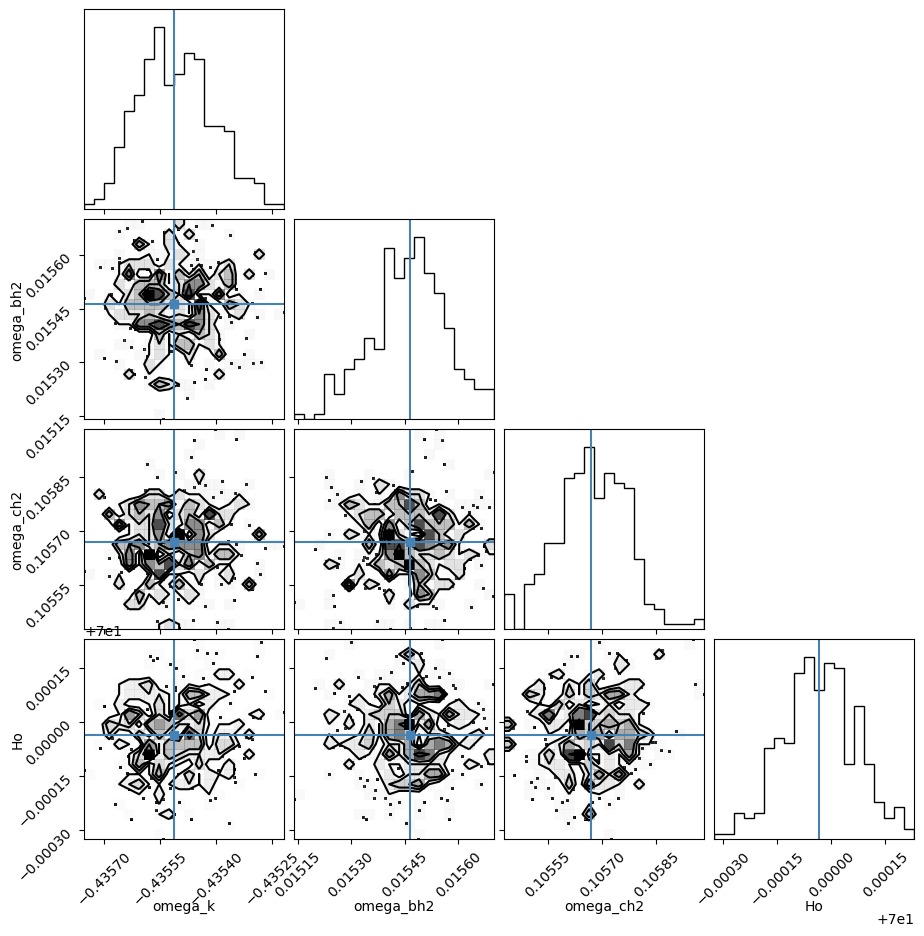

In [162]:
import corner
flat_samples = sampler.get_chain(discard=350, thin=40, flat=True)
fig = corner.corner(
    flat_samples, labels=labels, truths=best_fit_params.x)

In [163]:
from IPython.display import display, Math

for i in range(4):
    mcmc = np.percentile(flat_samples[:, i], [2.28, 50, 97.7])
    q = np.diff(mcmc)
    minimum = mcmc[1]-q[0]
    maximum = mcmc[1]+q[1]
    #print(f"{minimum} $\le \Omega \ge$ {maximum}")
    txt = "\mathrm{{{3}}} = {0:.2f}_{{{1:.2f}}}^{{{2:.2f}}}"
    txt = txt.format(mcmc[1], mcmc[1]-q[0], mcmc[1]+q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [53]:
xlist = np.linspace(0, 0.60, 1000)
ylist = np.linspace(0, 1.4, 1000)
parameters = np.meshgrid(xlist, ylist)
X=parameters[0]
Y=parameters[1]

In [54]:
Z = Chi_sq(parameters,68,2.8,H_obs,sigma,z)
Z2 =  Chi_sq(parameters,73.8,2.4,H_obs,sigma,z)

<ipython-input-33-1f0ce3c1f43a>:5: RuntimeWarning: invalid value encountered in sqrt
  return ((omega*((1+z)**3)) + (omega_R*((1+z)**2))+ omega_lambda)**(1/2)


In [55]:
print(Z)

[[33.37408887 33.33210405 33.29060986 ... 96.44667258 96.54717401
  96.64768605]
 [33.36286039 33.32050125 33.27863429 ... 96.36186198 96.46239065
  96.56292997]
 [33.35196087 33.309226   33.26698484 ... 96.27704146 96.37759736
  96.47816396]
 ...
 [        nan         nan         nan ... 44.37108247 44.40288731
  44.43510864]
 [        nan         nan         nan ... 44.46290572 44.4942494
  44.52601145]
 [        nan         nan         nan ... 44.55561446 44.5864944
  44.61779461]]


<ipython-input-105-10703363b397>:9: RuntimeWarning: divide by zero encountered in true_divide
  omega_lambda_nobigbang= 4*xlist*((np.cosh(np.arccosh((1-xlist)/(xlist))/3))**3)
<ipython-input-105-10703363b397>:9: RuntimeWarning: invalid value encountered in arccosh
  omega_lambda_nobigbang= 4*xlist*((np.cosh(np.arccosh((1-xlist)/(xlist))/3))**3)
<ipython-input-105-10703363b397>:9: RuntimeWarning: invalid value encountered in multiply
  omega_lambda_nobigbang= 4*xlist*((np.cosh(np.arccosh((1-xlist)/(xlist))/3))**3)
<ipython-input-105-10703363b397>:42: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax1.text(0.4,0.23,"Acceleration",Rotation="10",weight="bold")
<ipython-input-105-10703363b397>:43: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax1.text(0.4,0.12,"Deceleration",Rotation="10",weight="bold")
<ipython-in

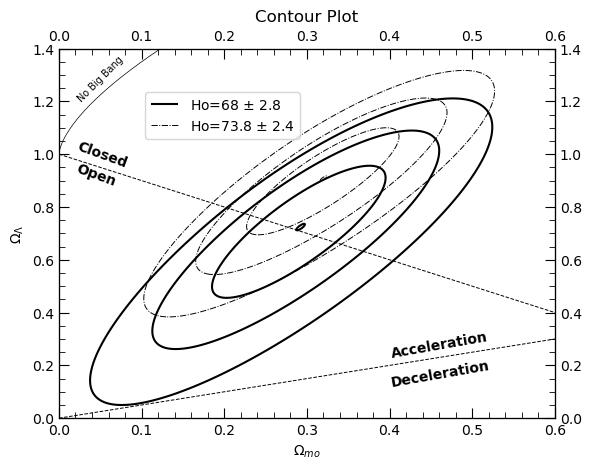

In [105]:
fig, ax1 = plt.subplots()

#drawing contour plot

cb = ax1.contour(X, Y, Z2,levels=[19.105,21.4,25.27,30.9],colors="black",linewidths=0.7,linestyles="dashdot")
cb2 = ax1.contour(X, Y, Z,levels=[18.075,20.37,24.24,29.87],colors="black")
flat_lambda_CDM = ax1.plot(xlist,1-xlist,c="black",ls="--",lw=0.7)
acceleration_line=ax1.plot(xlist,xlist/2,c="black",ls="--",lw=0.7)
omega_lambda_nobigbang= 4*xlist*((np.cosh(np.arccosh((1-xlist)/(xlist))/3))**3)
nobigbang= ax1.plot(xlist,omega_lambda_nobigbang,c="black",lw=0.5)
#Adding a colorbar to the plot
#fig.colorbar(cb) 

ax2 = ax1.twinx()
ax2.tick_params(direction='in')
ax2.set_ylim(0,1.4)
ax3= ax1.twiny()
ax3.tick_params(direction='in')
ax3.set_xlim(0,0.6)
ax3.xaxis.set_major_locator(MultipleLocator(0.1))
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_major_locator(MultipleLocator(0.2))
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which ='both',direction='in')
ax2.tick_params(which='major', length=7)
ax2.tick_params(which='minor', length=4)
ax3.tick_params(which ='both',direction='in')
ax3.tick_params(which='major', length=7)
ax3.tick_params(which='minor', length=4)
        
ax1.set_title('Contour Plot')
ax1.set_xlabel('$\Omega_{mo}$')
ax1.set_ylabel('$\Omega_{\Lambda}$')
ax1.set_ylim(0,1.4)
ax1.xaxis.set_major_locator(MultipleLocator(0.1))
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_major_locator(MultipleLocator(0.2))
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which ='both',direction='in')
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.text(0.4,0.23,"Acceleration",Rotation="10",weight="bold")
ax1.text(0.4,0.12,"Deceleration",Rotation="10",weight="bold")
ax1.text(0.018,0.88,"Open",Rotation="-20",weight="bold")
ax1.text(0.02,0.95,"Closed",Rotation="-20",weight="bold")
ax1.text(0.02,1.2,"No Big Bang",Rotation="45",size="x-small")
#ax2.plot("--")

lines = [ cb2.collections[0],cb.collections[0]]
labels = ['Ho=68 $\pm$ 2.8','Ho=73.8 $\pm$ 2.4']
#ax.legend(["1","2"],loc=4,bbox_to_anchor=(1.1, 0.0))
#Ho=68 $\pm$ 2.8
#Ho=73.8 $\pm$ 2.4
plt.legend(lines, labels,bbox_to_anchor=(0.5, 0.9))
plt.show()